<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_GRU/CNN_GRU_EURCHF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 2.16 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 17:26:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [8]:
# storing the file to be read as a string
in_str = 'EURCHF'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_GRU'
# setting our window_length to be 30 days
window_len = 30

In [9]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [10]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 5.4 MB/s 
     |████████████████████████████████| 138 kB 65.3 MB/s 
     |████████████████████████████████| 170 kB 71.1 MB/s 
     |████████████████████████████████| 97 kB 8.2 MB/s 
     |████████████████████████████████| 133 kB 61.5 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [11]:
!pip install wandb -qq

In [12]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [13]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [14]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(GRU(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [15]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: xtdtnezx
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_GRU/sweeps/xtdtnezx


In [17]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: elng4djs with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 4s 111ms/step - loss: 0.1476 - mean_squared_error: 0.1476 - mean_absolute_error: 0.3094 - val_loss: 0.0589 - val_mean_squared_error: 0.0589 - val_mean_absolute_error: 0.1838
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0236 - mean_squared_error: 0.0236 - mean_absolute_error: 0.1102 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1351
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.0952 - val_loss: 0.0394 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1517
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0784 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1206
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - me

epoch,49
loss,0.00183
mean_squared_error,0.00183
mean_absolute_error,0.02214
val_loss,0.00746
val_mean_squared_error,0.00746
val_mean_absolute_error,0.06425
_runtime,12
_timestamp,1626888836
_step,49
best_val_loss,0.00741


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▅▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▅▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▆▄▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆████████
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: y1i28xy0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 4s 121ms/step - loss: 0.1193 - mean_squared_error: 0.1193 - mean_absolute_error: 0.2610 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.1438
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0422 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1365
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0406 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1253
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0409 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1188
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.00

epoch,47
loss,0.00241
mean_squared_error,0.00241
mean_absolute_error,0.02637
val_loss,0.01013
val_mean_squared_error,0.01013
val_mean_absolute_error,0.08095
_runtime,13
_timestamp,1626888860
_step,47
best_val_loss,0.00869


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▁▃▃▁▁▁▃▂▁▁▁▁▁▄▁▁▁▁▁▁▁▂▁▁▂▁▁▁
val_loss,█▇▆▅▅▃▃▃▃▂▂▂▁▃▂▁▁▂▃▂▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▅▃▃▃▃▂▂▂▁▃▂▁▁▂▃▂▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▃▃▄▂▂▂▂▂▄▂▂▂▂▃▂▂▁▁▁▁▂▂▂▁▂▁▁▂▂▂▁▂▂▁▂
_runtime,▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 22i00l7a with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 3s 28ms/step - loss: 0.2315 - mean_squared_error: 0.2315 - mean_absolute_error: 0.3989 - val_loss: 0.0493 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1898
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0973 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1461
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0724 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1459
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0686 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1387
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0106 - mean_squared_erro

epoch,99
loss,0.00416
mean_squared_error,0.00416
mean_absolute_error,0.03131
val_loss,0.01183
val_mean_squared_error,0.01183
val_mean_absolute_error,0.08262
_runtime,27
_timestamp,1626888899
_step,99
best_val_loss,0.01171


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ot4sqfly with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 4s 30ms/step - loss: 0.0835 - mean_squared_error: 0.0835 - mean_absolute_error: 0.1929 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1186
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.0901 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0953
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0666 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0776
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0774 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0834
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.

epoch,49
loss,0.00257
mean_squared_error,0.00257
mean_absolute_error,0.02718
val_loss,0.00415
val_mean_squared_error,0.00415
val_mean_absolute_error,0.04892
_runtime,21
_timestamp,1626888954
_step,49
best_val_loss,0.00409


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▃▂▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▃▂▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▄▃▂▂▃▂▃▂▂▃▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_loss,█▅▃▄▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
val_mean_squared_error,█▅▃▄▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
val_mean_absolute_error,▇▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8qw2k9lr with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 3s 29ms/step - loss: 0.1490 - mean_squared_error: 0.1490 - mean_absolute_error: 0.3082 - val_loss: 0.0412 - val_mean_squared_error: 0.0412 - val_mean_absolute_error: 0.1659
Epoch 2/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0701 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1421
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0566 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1409
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0531 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1388
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0074 - mean_squared_erro

epoch,199
loss,0.00335
mean_squared_error,0.00335
mean_absolute_error,0.02866
val_loss,0.00815
val_mean_squared_error,0.00815
val_mean_absolute_error,0.06675
_runtime,50
_timestamp,1626889016
_step,199
best_val_loss,0.00811


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▅▄▄▄▃▄▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▅▅▄▄▄▃▄▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: koukffsc with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 3s 161ms/step - loss: 9.2513 - mean_squared_error: 9.2513 - mean_absolute_error: 1.8460 - val_loss: 0.1034 - val_mean_squared_error: 0.1034 - val_mean_absolute_error: 0.2411
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0998 - val_loss: 0.1045 - val_mean_squared_error: 0.1045 - val_mean_absolute_error: 0.2409
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1079 - val_loss: 0.5337 - val_mean_squared_error: 0.5337 - val_mean_absolute_error: 0.6933
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1813 - mean_squared_error: 0.1813 - mean_absolute_error: 0.3239 - val_loss: 0.1068 - val_mean_squared_error: 0.1068 - val_mean_absolute_error: 0.2834
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1243 - mean_squared_error: 0.1243

epoch,32
loss,0.00948
mean_squared_error,0.00948
mean_absolute_error,0.06844
val_loss,0.01625
val_mean_squared_error,0.01625
val_mean_absolute_error,0.0958
_runtime,11
_timestamp,1626889079
_step,32
best_val_loss,0.01136


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂█▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▂█▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▃█▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▂▁
_runtime,▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆█████████
_timestamp,▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆█████████
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 2vaxggzn with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 61ms/step - loss: 0.2874 - mean_squared_error: 0.2874 - mean_absolute_error: 0.3519 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1222
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0378 - mean_squared_error: 0.0378 - mean_absolute_error: 0.1415 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1175
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0316 - mean_squared_error: 0.0316 - mean_absolute_error: 0.1390 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1084
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.1439 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1012
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0360 - mean_squared_erro

epoch,74
loss,0.00332
mean_squared_error,0.00332
mean_absolute_error,0.03523
val_loss,0.00575
val_mean_squared_error,0.00575
val_mean_absolute_error,0.05847
_runtime,18
_timestamp,1626889109
_step,74
best_val_loss,0.0041


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▃▄▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▄▄▅▃▆▃▄▂▂▂▄▂▂▂▂▂▃▁▂▂▃▁▁▁▁▂▂▁▂▁▁▁▁▃▂▂▂
val_mean_squared_error,██▆▄▄▅▃▆▃▄▂▂▂▄▂▂▂▂▂▃▁▂▂▃▁▁▁▁▂▂▁▂▁▁▁▁▃▂▂▂
val_mean_absolute_error,██▆▅▄▆▃▆▃▄▃▃▂▄▂▂▂▃▂▃▂▂▂▄▂▁▁▁▂▂▁▂▁▁▁▁▄▂▂▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rton9eu2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 117ms/step - loss: 0.1411 - mean_squared_error: 0.1411 - mean_absolute_error: 0.2807 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1363
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0447 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1284
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0432 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1200
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0446 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1119
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - m

epoch,49
loss,0.00228
mean_squared_error,0.00228
mean_absolute_error,0.02428
val_loss,0.01045
val_mean_squared_error,0.01045
val_mean_absolute_error,0.07948
_runtime,13
_timestamp,1626889136
_step,49
best_val_loss,0.01024


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▃▂▃▂▂▂▁▃▁▂▁▂▁▃▁▁▁▁▁▁▁▁▁▂▂▁▁▂▁▁▁▂▁
val_loss,█▇▅▅▃▃▄▄▃▃▃▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁
val_mean_squared_error,█▇▅▅▃▃▄▄▃▃▃▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▇▆▅▃▃▃▄▂▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5ffs4qw0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 4s 32ms/step - loss: 0.2179 - mean_squared_error: 0.2179 - mean_absolute_error: 0.2528 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1200
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0307 - mean_squared_error: 0.0307 - mean_absolute_error: 0.1192 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1067
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - mean_absolute_error: 0.0910 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1079
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0739 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.1309
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0159 - mean_squared_erro

epoch,61
loss,0.00263
mean_squared_error,0.00263
mean_absolute_error,0.02931
val_loss,0.00419
val_mean_squared_error,0.00419
val_mean_absolute_error,0.04881
_runtime,21
_timestamp,1626889173
_step,61
best_val_loss,0.00404


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▅██▇█▃▂▂▂▂▂▃▂▂▂▂▁▁▁▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆▅██▇█▃▂▂▂▂▂▃▂▂▂▂▁▁▁▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆▅▇▇▇█▃▂▃▂▂▃▃▂▂▃▂▁▂▁▃▂▁▂▁▁▃▁▁▁▁▁▂▁▂▁▂▂▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0unprdy8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 3s 29ms/step - loss: 0.1483 - mean_squared_error: 0.1483 - mean_absolute_error: 0.3061 - val_loss: 0.0497 - val_mean_squared_error: 0.0497 - val_mean_absolute_error: 0.1836
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0697 - val_loss: 0.0371 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1635
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0642 - val_loss: 0.0367 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1621
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0581 - val_loss: 0.0352 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1584
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0081 - mean_squared_error: 0.

epoch,49
loss,0.00477
mean_squared_error,0.00477
mean_absolute_error,0.03764
val_loss,0.01563
val_mean_squared_error,0.01563
val_mean_absolute_error,0.09952
_runtime,19
_timestamp,1626889205
_step,49
best_val_loss,0.01563


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qb5lt91y with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 4s 56ms/step - loss: 0.1006 - mean_squared_error: 0.1006 - mean_absolute_error: 0.2539 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1411
Epoch 2/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0688 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1364
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0466 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1304
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0412 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1249
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_squared_err

epoch,199
loss,0.00224
mean_squared_error,0.00224
mean_absolute_error,0.0213
val_loss,0.00543
val_mean_squared_error,0.00543
val_mean_absolute_error,0.05483
_runtime,36
_timestamp,1626889264
_step,199
best_val_loss,0.00539


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: z6wu0gl5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 3s 61ms/step - loss: 0.2734 - mean_squared_error: 0.2734 - mean_absolute_error: 0.4347 - val_loss: 0.0621 - val_mean_squared_error: 0.0621 - val_mean_absolute_error: 0.2076
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.1622 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1352
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0694 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1304
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0623 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1322
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0072 - mean_squared_error: 0.

epoch,49
loss,0.00499
mean_squared_error,0.00499
mean_absolute_error,0.03758
val_loss,0.01438
val_mean_squared_error,0.01438
val_mean_absolute_error,0.09224
_runtime,16
_timestamp,1626889296
_step,49
best_val_loss,0.01438


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7l03htsx with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 4s 122ms/step - loss: 0.2261 - mean_squared_error: 0.2261 - mean_absolute_error: 0.3869 - val_loss: 0.0541 - val_mean_squared_error: 0.0541 - val_mean_absolute_error: 0.1787
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0420 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1684 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1291
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0728 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1211
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0628 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1064
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0079 - mean_squared_error: 0.0079

epoch,76
loss,0.0023
mean_squared_error,0.0023
mean_absolute_error,0.02267
val_loss,0.00436
val_mean_squared_error,0.00436
val_mean_absolute_error,0.05013
_runtime,17
_timestamp,1626889328
_step,76
best_val_loss,0.00432


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: u2006ge3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 4s 32ms/step - loss: 0.4301 - mean_squared_error: 0.4301 - mean_absolute_error: 0.4498 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1301
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0461 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1158
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0389 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1115
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0311 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0902
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.

epoch,40
loss,0.0024
mean_squared_error,0.0024
mean_absolute_error,0.02678
val_loss,0.00959
val_mean_squared_error,0.00959
val_mean_absolute_error,0.07215
_runtime,19
_timestamp,1626889362
_step,40
best_val_loss,0.00871


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▃▃▃▄▃▃▂▂▂▂▂▂▃▁▁▂▂▂▂▂▂▂▁▂▁▂▁▁▂▂▂▂▂▁▂▂▁
val_mean_squared_error,█▆▅▃▃▃▄▃▃▂▂▂▂▂▂▃▁▁▂▂▂▂▂▂▂▁▂▁▂▁▁▂▂▂▂▂▁▂▂▁
val_mean_absolute_error,█▆▆▄▄▃▄▃▃▂▂▂▂▂▂▃▁▁▂▂▂▂▂▂▂▁▂▁▂▁▁▂▂▂▂▂▁▂▂▂
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: 354mxhxz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 3s 59ms/step - loss: 0.1523 - mean_squared_error: 0.1523 - mean_absolute_error: 0.3166 - val_loss: 0.0613 - val_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.2080
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error: 0.0983 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1397
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0711 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1420
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0528 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1319
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0080 - mean_squared_error: 0.

epoch,49
loss,0.00428
mean_squared_error,0.00428
mean_absolute_error,0.02993
val_loss,0.01243
val_mean_squared_error,0.01243
val_mean_absolute_error,0.08457
_runtime,17
_timestamp,1626889394
_step,49
best_val_loss,0.01243


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: sz7acf4u with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 3s 30ms/step - loss: 4.7303 - mean_squared_error: 4.7303 - mean_absolute_error: 0.9962 - val_loss: 0.1441 - val_mean_squared_error: 0.1441 - val_mean_absolute_error: 0.3176
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0899 - mean_squared_error: 0.0899 - mean_absolute_error: 0.2515 - val_loss: 0.1681 - val_mean_squared_error: 0.1681 - val_mean_absolute_error: 0.3752
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0508 - mean_squared_error: 0.0508 - mean_absolute_error: 0.1668 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1216
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0296 - mean_squared_error: 0.0296 - mean_absolute_error: 0.1304 - val_loss: 0.0364 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1601
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0149 - mean_squared_erro

epoch,25
loss,0.00446
mean_squared_error,0.00446
mean_absolute_error,0.04142
val_loss,0.01553
val_mean_squared_error,0.01553
val_mean_absolute_error,0.09868
_runtime,14
_timestamp,1626889425
_step,25
best_val_loss,0.01105


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▂▃▂▂▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▄▄▄▄▅▅▅▅▅▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▄▄▄▄▅▅▅▅▅▇▇▇▇█████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 8qt5zltf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 4s 61ms/step - loss: 0.4573 - mean_squared_error: 0.4573 - mean_absolute_error: 0.5116 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1269
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.1020 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1357
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0504 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.0983
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0413 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0744
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_squared_erro

epoch,19
loss,0.00231
mean_squared_error,0.00231
mean_absolute_error,0.0256
val_loss,0.00853
val_mean_squared_error,0.00853
val_mean_absolute_error,0.06817
_runtime,13
_timestamp,1626889454
_step,19
best_val_loss,0.00843


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▄▂▁▁▁▂▂▁▂▁▂▂▁▂▁▁▃▁
val_mean_squared_error,▇█▄▂▁▁▁▂▂▁▂▁▂▂▁▂▁▁▃▁
val_mean_absolute_error,▇█▄▂▁▁▂▂▂▁▂▂▂▂▂▂▂▂▃▁
_runtime,▁▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆▆▆██
_timestamp,▁▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆▆▆██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 3h12dpkm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 4s 62ms/step - loss: 0.3262 - mean_squared_error: 0.3262 - mean_absolute_error: 0.3571 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.1324
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0494 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1119
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0531 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1025
Epoch 4/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0473 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1250
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0038 - mean_squared_err

epoch,37
loss,0.00269
mean_squared_error,0.00269
mean_absolute_error,0.03081
val_loss,0.00984
val_mean_squared_error,0.00984
val_mean_absolute_error,0.07459
_runtime,16
_timestamp,1626889487
_step,37
best_val_loss,0.00979


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁▂▂▁▁▁▂▁▁▁▂▁▁▂▁▁▁▁
val_loss,█▅▄▇▃▅▃▄▇▄▂▂▃▂▂▅▃▂▂▂▂▂▃▁▁▃▁▁▁▁▁▂▁▁▂▁▁▁
val_mean_squared_error,█▅▄▇▃▅▃▄▇▄▂▂▃▂▂▅▃▂▂▂▂▂▃▁▁▃▁▁▁▁▁▂▁▁▂▁▁▁
val_mean_absolute_error,█▅▄▇▄▅▄▅█▄▂▂▃▂▂▅▃▂▂▂▂▂▃▁▁▃▂▁▁▁▁▁▁▁▂▂▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2lkt7sjn with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 3s 58ms/step - loss: 0.1255 - mean_squared_error: 0.1255 - mean_absolute_error: 0.2752 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1327
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0943 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1156
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0515 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0988
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0442 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0877
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0047 - mean_squared_erro

epoch,65
loss,0.00237
mean_squared_error,0.00237
mean_absolute_error,0.02695
val_loss,0.00418
val_mean_squared_error,0.00418
val_mean_absolute_error,0.05108
_runtime,20
_timestamp,1626889523
_step,65
best_val_loss,0.00407


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▃▃▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 9xy3zhwb with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 3s 31ms/step - loss: 0.0890 - mean_squared_error: 0.0890 - mean_absolute_error: 0.2148 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1045
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0535 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0797
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0379 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0727
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0442 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0675
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.

epoch,49
loss,0.00227
mean_squared_error,0.00227
mean_absolute_error,0.02389
val_loss,0.0041
val_mean_squared_error,0.0041
val_mean_absolute_error,0.05022
_runtime,21
_timestamp,1626889560
_step,49
best_val_loss,0.00391


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▂▂▁▁▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▂▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▂▂▃▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5cpjgq3c with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 4s 62ms/step - loss: 0.1107 - mean_squared_error: 0.1107 - mean_absolute_error: 0.2564 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1305
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0819 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1196
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0557 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1126
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0416 - val_loss: 0.0174 - val_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.1027
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_squared_erro

epoch,38
loss,0.00259
mean_squared_error,0.00259
mean_absolute_error,0.02774
val_loss,0.00684
val_mean_squared_error,0.00684
val_mean_absolute_error,0.0605
_runtime,18
_timestamp,1626889601
_step,38
best_val_loss,0.00604


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rjob8cmk with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 114ms/step - loss: 0.1982 - mean_squared_error: 0.1982 - mean_absolute_error: 0.3843 - val_loss: 0.0473 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1868
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - mean_absolute_error: 0.1425 - val_loss: 0.0571 - val_mean_squared_error: 0.0571 - val_mean_absolute_error: 0.2004
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0980 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1398
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0822 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1428
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0104 - mean_squared_error: 0.0104

epoch,99
loss,0.00449
mean_squared_error,0.00449
mean_absolute_error,0.03062
val_loss,0.01332
val_mean_squared_error,0.01332
val_mean_absolute_error,0.08786
_runtime,20
_timestamp,1626889637
_step,99
best_val_loss,0.01332


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ztwfrafd with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 89ms/step - loss: 0.1368 - mean_squared_error: 0.1368 - mean_absolute_error: 0.2504 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1325
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0742 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1278
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0824 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1290
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0674 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1069
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0118 - mean_squared_error: 0.

epoch,49
loss,0.00278
mean_squared_error,0.00278
mean_absolute_error,0.02764
val_loss,0.00472
val_mean_squared_error,0.00472
val_mean_absolute_error,0.05142
_runtime,19
_timestamp,1626889672
_step,49
best_val_loss,0.00465


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▃▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▃▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▃▂▄▂▂▂▂▂▂▂▃▂▂▃▂▂▁▂▂▁▂▂▂▂▁▂▁▁▂▁▁▂▂▁▁▂▁
val_loss,███▅▃▂▂▃▂▂▂▄▂▂▂▂▂▄▂▁▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁
val_mean_squared_error,███▅▃▂▂▃▂▂▂▄▂▂▂▂▂▄▂▁▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁
val_mean_absolute_error,███▆▃▃▃▃▃▂▃▄▂▂▃▃▂▄▂▂▃▂▂▅▂▁▂▂▁▁▂▁▁▁▁▁▁▂▂▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gusucz37 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 4s 31ms/step - loss: 1.7246 - mean_squared_error: 1.7246 - mean_absolute_error: 0.6681 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1424
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0672 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0945
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0528 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0768
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0536 - val_loss: 0.2199 - val_mean_squared_error: 0.2199 - val_mean_absolute_error: 0.4233
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0662 - mean_squared_error: 0.

epoch,48
loss,0.00292
mean_squared_error,0.00292
mean_absolute_error,0.03155
val_loss,0.00394
val_mean_squared_error,0.00394
val_mean_absolute_error,0.0491
_runtime,25
_timestamp,1626889715
_step,48
best_val_loss,0.0037


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▂▂█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jqgiqokv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 3s 60ms/step - loss: 0.1087 - mean_squared_error: 0.1087 - mean_absolute_error: 0.2518 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1376
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0694 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1295
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0485 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1211
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0408 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1095
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_squared_erro

epoch,36
loss,0.00225
mean_squared_error,0.00225
mean_absolute_error,0.02443
val_loss,0.00705
val_mean_squared_error,0.00705
val_mean_absolute_error,0.06499
_runtime,16
_timestamp,1626889746
_step,36
best_val_loss,0.00676


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▃▃▂▂▂▂▂▂▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███████
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: q34l78gf with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 4s 199ms/step - loss: 0.1425 - mean_squared_error: 0.1425 - mean_absolute_error: 0.3026 - val_loss: 0.0483 - val_mean_squared_error: 0.0483 - val_mean_absolute_error: 0.1663
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0316 - mean_squared_error: 0.0316 - mean_absolute_error: 0.1411 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1248
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0783 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1318
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0709 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1116
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0094 - mean_squared_error: 0.00

epoch,58
loss,0.00292
mean_squared_error,0.00292
mean_absolute_error,0.03085
val_loss,0.00486
val_mean_squared_error,0.00486
val_mean_absolute_error,0.05516
_runtime,18
_timestamp,1626889780
_step,58
best_val_loss,0.00482


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: v2pieqgz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 60ms/step - loss: 0.1354 - mean_squared_error: 0.1354 - mean_absolute_error: 0.2730 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1542
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0860 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1276
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0456 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1115
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0359 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0977
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0060 - mean_squared_error: 0.

epoch,44
loss,0.00203
mean_squared_error,0.00203
mean_absolute_error,0.02266
val_loss,0.00893
val_mean_squared_error,0.00893
val_mean_absolute_error,0.07199
_runtime,17
_timestamp,1626889814
_step,44
best_val_loss,0.00816


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▁▁▁▂▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,█▅▄▃▂▂▂▁▁▁▂▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▆▅▃▃▃▃▂▂▂▂▂▂▂▁▂▂▃▂▂▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂▂▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: nu2sqg52 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 3s 56ms/step - loss: 0.3788 - mean_squared_error: 0.3788 - mean_absolute_error: 0.5469 - val_loss: 0.0376 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1524
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - mean_absolute_error: 0.0992 - val_loss: 0.0512 - val_mean_squared_error: 0.0512 - val_mean_absolute_error: 0.1880
Epoch 3/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - mean_absolute_error: 0.1086 - val_loss: 0.0356 - val_mean_squared_error: 0.0356 - val_mean_absolute_error: 0.1611
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0787 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.1513
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0102 - mean_squared_err

epoch,199
loss,0.00418
mean_squared_error,0.00418
mean_absolute_error,0.03374
val_loss,0.01139
val_mean_squared_error,0.01139
val_mean_absolute_error,0.08102
_runtime,42
_timestamp,1626889871
_step,199
best_val_loss,0.01131


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: n54qnqvi with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 4s 32ms/step - loss: 0.6687 - mean_squared_error: 0.6687 - mean_absolute_error: 0.3695 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1343
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - mean_absolute_error: 0.0988 - val_loss: 0.0578 - val_mean_squared_error: 0.0578 - val_mean_absolute_error: 0.1979
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0313 - mean_squared_error: 0.0313 - mean_absolute_error: 0.1441 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1002
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0746 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1254
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0118 - mean_squared_erro

epoch,41
loss,0.00353
mean_squared_error,0.00353
mean_absolute_error,0.03723
val_loss,0.00486
val_mean_squared_error,0.00486
val_mean_absolute_error,0.05522
_runtime,20
_timestamp,1626889915
_step,41
best_val_loss,0.00397


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▃▄▂▂▂▃▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄█▃▄▂▂▂▃▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▃▅▂▂▂▃▃▂▂▂▃▁▂▂▂▁▂▁▁▁▁▁▂▁▁▂▁▃▁▁▁▁▁▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: 577zamaq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 61ms/step - loss: 0.1625 - mean_squared_error: 0.1625 - mean_absolute_error: 0.3069 - val_loss: 0.0340 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1405
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1087 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1304
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0538 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1285
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0411 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1139
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.

epoch,43
loss,0.00199
mean_squared_error,0.00199
mean_absolute_error,0.02304
val_loss,0.00689
val_mean_squared_error,0.00689
val_mean_absolute_error,0.06187
_runtime,17
_timestamp,1626889950
_step,43
best_val_loss,0.00674


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▂▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 665fhir5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 118ms/step - loss: 0.1388 - mean_squared_error: 0.1388 - mean_absolute_error: 0.2705 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1356
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0433 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1290
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0428 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1169
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0474 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1084
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0063 - mean_squared_error: 0.00

epoch,38
loss,0.00452
mean_squared_error,0.00452
mean_absolute_error,0.04526
val_loss,0.00931
val_mean_squared_error,0.00931
val_mean_absolute_error,0.0778
_runtime,15
_timestamp,1626889980
_step,38
best_val_loss,0.00824


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
mean_squared_error,█▁▁▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▃▃▂▂▂▄▂▁▁▁▂▂▂▃▁▃▂▂▂▂▁▂▁▂▂▁▁▁▄▂▁▁▂
val_loss,█▇▅▄▄▃▃▃▂▂█▂▂▂▁▂▁▂▃▂▁▁▁▂▁▁▁▁▁▂▁▁▁▂▂▁▁▁▁
val_mean_squared_error,█▇▅▄▄▃▃▃▂▂█▂▂▂▁▂▁▂▃▂▁▁▁▂▁▁▁▁▁▂▁▁▁▂▂▁▁▁▁
val_mean_absolute_error,▇▇▆▅▄▄▃▃▃▂█▂▂▂▂▁▂▂▃▂▂▂▂▃▁▂▂▁▁▂▁▁▁▂▂▂▁▁▂
_runtime,▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2slxdr5q with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 4s 33ms/step - loss: 0.0705 - mean_squared_error: 0.0705 - mean_absolute_error: 0.1957 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1337
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0504 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0928
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0347 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0827
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0301 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0832
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.

epoch,49
loss,0.00209
mean_squared_error,0.00209
mean_absolute_error,0.02483
val_loss,0.0072
val_mean_squared_error,0.0072
val_mean_absolute_error,0.06527
_runtime,24
_timestamp,1626890021
_step,49
best_val_loss,0.0068


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▂▃▂▂▂▂▁▂▂▂▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▃▂▂▂▂▁▂▂▂▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▃▂▂▂▂▄▂▂▃▃▂▃▂▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: aox32znr with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 4s 124ms/step - loss: 0.1867 - mean_squared_error: 0.1867 - mean_absolute_error: 0.3696 - val_loss: 0.0436 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1592
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1472 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1114
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0542 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1300
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - mean_absolute_error: 0.1262 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1191
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0128 - mean_squared_error: 0.01

epoch,137
loss,0.00243
mean_squared_error,0.00243
mean_absolute_error,0.02783
val_loss,0.00495
val_mean_squared_error,0.00495
val_mean_absolute_error,0.05307
_runtime,27
_timestamp,1626890071
_step,137
best_val_loss,0.00392


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▅▅▅▂▂█▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▅▅▅▂▂█▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▆▆▆▂▂█▂▃▂▂▂▂▂▂▁▂▂▁▁▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▂▁
val_loss,▆█▆▃▃▄▂▂▃▂▂▂▂▂▁▂▁▂▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,▆█▆▃▃▄▂▂▃▂▂▂▂▂▁▂▁▂▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,▇█▇▄▄▅▃▃▃▂▂▂▂▂▂▂▁▃▂▂▂▁▂▁▁▁▁▂▁▂▁▂▁▂▁▁▁▁▂▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qq4uelju with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 116ms/step - loss: 0.1469 - mean_squared_error: 0.1469 - mean_absolute_error: 0.3097 - val_loss: 0.0644 - val_mean_squared_error: 0.0644 - val_mean_absolute_error: 0.1946
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - mean_absolute_error: 0.1074 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1308
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0984 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1419
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0659 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1192
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.00

epoch,55
loss,0.00203
mean_squared_error,0.00203
mean_absolute_error,0.0224
val_loss,0.0059
val_mean_squared_error,0.0059
val_mean_absolute_error,0.05725
_runtime,17
_timestamp,1626890104
_step,55
best_val_loss,0.00578


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: fk1a0omx with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 4s 32ms/step - loss: 0.0802 - mean_squared_error: 0.0802 - mean_absolute_error: 0.2025 - val_loss: 0.0323 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1399
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0486 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1037
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0463 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0892
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0343 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0755
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_squared_erro

epoch,41
loss,0.00234
mean_squared_error,0.00234
mean_absolute_error,0.02604
val_loss,0.00808
val_mean_squared_error,0.00808
val_mean_absolute_error,0.06903
_runtime,22
_timestamp,1626890141
_step,41
best_val_loss,0.00725


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▁▂▂▂▁▂▁▁▁▂▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▁▂▂▂▁▂▁▁▁▂▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▂▂▂▁▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: kdp9xe6g with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 130ms/step - loss: 0.1674 - mean_squared_error: 0.1674 - mean_absolute_error: 0.3528 - val_loss: 0.0469 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1855
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - mean_absolute_error: 0.1253 - val_loss: 0.0588 - val_mean_squared_error: 0.0588 - val_mean_absolute_error: 0.2016
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.0911 - val_loss: 0.0323 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1523
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0778 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1533
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0095 - mean_squared_error: 0.009

epoch,99
loss,0.0047
mean_squared_error,0.0047
mean_absolute_error,0.03272
val_loss,0.01416
val_mean_squared_error,0.01416
val_mean_absolute_error,0.09167
_runtime,23
_timestamp,1626890183
_step,99
best_val_loss,0.01409


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hh1ip9ki with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 3s 29ms/step - loss: 0.1677 - mean_squared_error: 0.1677 - mean_absolute_error: 0.3190 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1397
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0643 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1337
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0561 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1287
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0506 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1243
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0084 - mean_squared_error: 0.

epoch,49
loss,0.00428
mean_squared_error,0.00428
mean_absolute_error,0.034
val_loss,0.01103
val_mean_squared_error,0.01103
val_mean_absolute_error,0.07841
_runtime,23
_timestamp,1626890228
_step,49
best_val_loss,0.01103


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: oalmh2nw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 4s 35ms/step - loss: 0.0988 - mean_squared_error: 0.0988 - mean_absolute_error: 0.1906 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1340
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0435 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0992
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0355 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0886
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0403 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0898
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_err

epoch,53
loss,0.00235
mean_squared_error,0.00235
mean_absolute_error,0.02438
val_loss,0.00736
val_mean_squared_error,0.00736
val_mean_absolute_error,0.06571
_runtime,27
_timestamp,1626890270
_step,53
best_val_loss,0.00727


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▃▃▂▂▂▁▂▁▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▁▂▂▂▂▂▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▂▁▂▂▂▂▂▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▃▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qurt9w1j with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 4s 32ms/step - loss: 0.0497 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1227 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1065
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0714 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0922
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0335 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0819
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0428 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0837
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.

epoch,24
loss,0.00264
mean_squared_error,0.00264
mean_absolute_error,0.02801
val_loss,0.00821
val_mean_squared_error,0.00821
val_mean_absolute_error,0.0678
_runtime,19
_timestamp,1626890304
_step,24
best_val_loss,0.00771


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▂▃▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▃▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▅▂▃▃▂▂▂▂▂▂▁▁▁▁▂▁▂▁▁▂▁▁
val_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▃▅▁▁▁▅▂▁▁▁
val_mean_squared_error,█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▃▅▁▁▁▅▂▁▁▁
val_mean_absolute_error,█▆▄▄▃▄▃▂▂▃▃▂▃▁▁▃▇▁▁▂▆▂▂▁▁
_runtime,▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇█
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: c0yabc3d with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 113ms/step - loss: 0.1800 - mean_squared_error: 0.1800 - mean_absolute_error: 0.3112 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1268
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0398 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1051
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_error: 0.0985 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1072
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0498 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1097
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0238 - mean_squared_error: 0.0238

epoch,27
loss,0.00454
mean_squared_error,0.00454
mean_absolute_error,0.04903
val_loss,0.01698
val_mean_squared_error,0.01698
val_mean_absolute_error,0.10588
_runtime,13
_timestamp,1626890332
_step,27
best_val_loss,0.01329


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▃▁▃▁▃▁▂▁▂▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▃▁▃▁▃▁▂▁▂▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▆▂▆▁▆▂▅▃▄▂▄▁▄▂▄▁▄▂▃▃▂▃▂▃▂▂
val_loss,▇▄▄▄▃▄▃▅▃▅▄▇▂▁▃▆▄▁▂▆▃▆▂▂█▂▃▃
val_mean_squared_error,▇▄▄▄▃▄▃▅▃▅▄▇▂▁▃▆▄▁▂▆▃▆▂▂█▂▃▃
val_mean_absolute_error,▇▄▄▄▄▄▃▅▄▅▄▇▃▂▄▆▅▁▂▄▂▄▁▂█▂▃▄
_runtime,▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅█████████
_timestamp,▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅█████████
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 56iy5w6m with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 4s 121ms/step - loss: 0.1388 - mean_squared_error: 0.1388 - mean_absolute_error: 0.2493 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1285
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0702 - val_loss: 0.0443 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1585
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0903 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1052
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0402 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1026
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - 

epoch,19
loss,0.00441
mean_squared_error,0.00441
mean_absolute_error,0.04596
val_loss,0.01211
val_mean_squared_error,0.01211
val_mean_absolute_error,0.08709
_runtime,13
_timestamp,1626890361
_step,19
best_val_loss,0.01203


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▁▂▃▁▁▁▁▁▁▂▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▂▃▁▁▁▁▁▁▂▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▂▄▇▁▁▂▁▂▃▄▂▁▃▂▂▂▂
val_loss,▄█▂▃▇▂▂▂▁▁▁▂▂▁▁▁▁▂▁▁
val_mean_squared_error,▄█▂▃▇▂▂▂▁▁▁▂▂▁▁▁▁▂▁▁
val_mean_absolute_error,▅█▃▃▇▂▂▁▁▁▂▃▂▁▁▁▂▂▂▁
_runtime,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅████
_timestamp,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅████
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: hu2f6ezp with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 3s 58ms/step - loss: 0.8027 - mean_squared_error: 0.8027 - mean_absolute_error: 0.4958 - val_loss: 0.0280 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1347
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0382 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1438 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1606
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - mean_absolute_error: 0.1381 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1197
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - mean_absolute_error: 0.1072 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1111
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0160 - mean_squared_erro

epoch,42
loss,0.00579
mean_squared_error,0.00579
mean_absolute_error,0.04933
val_loss,0.00515
val_mean_squared_error,0.00515
val_mean_absolute_error,0.05334
_runtime,16
_timestamp,1626890393
_step,42
best_val_loss,0.00464


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▂▂▁▁▁▂▁▂
val_loss,▅█▄▄▄▃▄▃▃▂▂▂▂▃▂▁▁▂▂▁▂▂▁▂▂▂▁▁▂▂▁▂▁▁▁▂▂▁▂▁
val_mean_squared_error,▅█▄▄▄▃▄▃▃▂▂▂▂▃▂▁▁▂▂▁▂▂▁▂▂▂▁▁▂▂▁▂▁▁▁▂▂▁▂▁
val_mean_absolute_error,▆█▅▅▅▄▄▃▃▃▃▃▃▄▂▂▂▂▄▂▂▃▁▃▃▃▂▁▂▂▁▂▁▂▁▃▂▁▃▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: ldz9hfnd with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 4s 124ms/step - loss: 0.8669 - mean_squared_error: 0.8669 - mean_absolute_error: 0.6522 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1413
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0586 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1395
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0899 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1185
Epoch 4/200
8/8 [==============================] - 0s 15ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0371 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1112
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0079 - mean_squared_error: 0.0

epoch,28
loss,0.00268
mean_squared_error,0.00268
mean_absolute_error,0.03107
val_loss,0.01239
val_mean_squared_error,0.01239
val_mean_absolute_error,0.08047
_runtime,15
_timestamp,1626890423
_step,28
best_val_loss,0.01199


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▁▁▁▂▂▁▁▂▂▁▁▂▁▁▁▁▁▂▂▁▁▁▁▂▁▁
val_loss,█▇▄▄▅▅▅█▅▃▆▅▃▅▄▂▂▁▁▁▃▂▂▁▃▃▅▂▁
val_mean_squared_error,█▇▄▄▅▅▅█▅▃▆▅▃▅▄▂▂▁▁▁▃▂▂▁▃▃▅▂▁
val_mean_absolute_error,██▅▅▅▅▅▇▅▄▆▅▄▅▄▃▂▂▁▂▄▃▂▂▂▃▄▂▁
_runtime,▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆█
_timestamp,▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆█
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: nv646oe9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 61ms/step - loss: 0.1728 - mean_squared_error: 0.1728 - mean_absolute_error: 0.3458 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1182
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0575 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0978
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0778 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0917
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0497 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0836
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0070 - mean_squared_

epoch,67
loss,0.00275
mean_squared_error,0.00275
mean_absolute_error,0.03018
val_loss,0.0044
val_mean_squared_error,0.0044
val_mean_absolute_error,0.05215
_runtime,24
_timestamp,1626890462
_step,67
best_val_loss,0.00422


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▃▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▄▃▄█▃▅▂▃▃▂▂▂▁▁▂▂▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆▄▃▄█▃▅▂▃▃▂▂▂▁▁▂▂▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆▅▄▄█▃▅▃▃▃▂▂▂▂▂▂▂▁▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rjnb36r5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 3s 123ms/step - loss: 0.6401 - mean_squared_error: 0.6401 - mean_absolute_error: 0.6469 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1338
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - mean_absolute_error: 0.1344 - val_loss: 0.0319 - val_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.1544
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - mean_absolute_error: 0.1171 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1371
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0693 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1194
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0075 - mean_squared_error: 0.00

epoch,26
loss,0.00232
mean_squared_error,0.00232
mean_absolute_error,0.02484
val_loss,0.01176
val_mean_squared_error,0.01176
val_mean_absolute_error,0.07696
_runtime,14
_timestamp,1626890492
_step,26
best_val_loss,0.00903


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇██▅▆▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
val_mean_squared_error,▇██▅▆▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂
val_mean_absolute_error,▆█▇▅▅▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂
_runtime,▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆████████
_timestamp,▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆████████
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: gju7u7pf with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 4s 99ms/step - loss: 0.1445 - mean_squared_error: 0.1445 - mean_absolute_error: 0.2815 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1399
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0641 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1047
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0454 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0893
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0410 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0771
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.

epoch,41
loss,0.00289
mean_squared_error,0.00289
mean_absolute_error,0.03167
val_loss,0.0051
val_mean_squared_error,0.0051
val_mean_absolute_error,0.05769
_runtime,18
_timestamp,1626890526
_step,41
best_val_loss,0.0042


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: pb8lyl8j with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 3s 32ms/step - loss: 0.2062 - mean_squared_error: 0.2062 - mean_absolute_error: 0.3507 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.1512
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0670 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.1469
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0594 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1423
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0541 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1387
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0074 - mean_squared_erro

epoch,99
loss,0.00308
mean_squared_error,0.00308
mean_absolute_error,0.02907
val_loss,0.00802
val_mean_squared_error,0.00802
val_mean_absolute_error,0.06662
_runtime,37
_timestamp,1626890578
_step,99
best_val_loss,0.008


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: u2jwoidb with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 3s 125ms/step - loss: 0.2369 - mean_squared_error: 0.2369 - mean_absolute_error: 0.3816 - val_loss: 0.0859 - val_mean_squared_error: 0.0859 - val_mean_absolute_error: 0.2345
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - mean_absolute_error: 0.1326 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1508
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0745 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1530
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0511 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1431
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - 

epoch,49
loss,0.00364
mean_squared_error,0.00364
mean_absolute_error,0.03035
val_loss,0.00982
val_mean_squared_error,0.00982
val_mean_absolute_error,0.07422
_runtime,17
_timestamp,1626890624
_step,49
best_val_loss,0.00982


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: e8kil0r3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 4s 138ms/step - loss: 2.8671 - mean_squared_error: 2.8671 - mean_absolute_error: 1.2915 - val_loss: 0.0774 - val_mean_squared_error: 0.0774 - val_mean_absolute_error: 0.2181
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.1804 - mean_squared_error: 0.1804 - mean_absolute_error: 0.3799 - val_loss: 0.3264 - val_mean_squared_error: 0.3264 - val_mean_absolute_error: 0.4448
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1053 - mean_squared_error: 0.1053 - mean_absolute_error: 0.2735 - val_loss: 0.0777 - val_mean_squared_error: 0.0777 - val_mean_absolute_error: 0.2304
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1342 - val_loss: 0.0488 - val_mean_squared_error: 0.0488 - val_mean_absolute_error: 0.1713
Epoch 5/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0177 - mean_squared_error: 0.01

epoch,64
loss,0.00299
mean_squared_error,0.00299
mean_absolute_error,0.03191
val_loss,0.00529
val_mean_squared_error,0.00529
val_mean_absolute_error,0.05391
_runtime,18
_timestamp,1626890658
_step,64
best_val_loss,0.00393


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: l9m2g3p4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 4s 32ms/step - loss: 0.5142 - mean_squared_error: 0.5142 - mean_absolute_error: 0.3388 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1536
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - mean_absolute_error: 0.1023 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1057
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0780 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1165
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0721 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1325
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0221 - mean_squared_error: 0.

epoch,35
loss,0.00313
mean_squared_error,0.00313
mean_absolute_error,0.03229
val_loss,0.00913
val_mean_squared_error,0.00913
val_mean_absolute_error,0.07857
_runtime,20
_timestamp,1626890694
_step,35
best_val_loss,0.00438


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▅▆▃▂▂▂▁▂▁▁▁▂▂▃▁▁▁▁▃▁▁▁▁▁▂▁▁▁▁▁▁▂▁▂
val_mean_squared_error,█▄▅▆▃▂▂▂▁▂▁▁▁▂▂▃▁▁▁▁▃▁▁▁▁▁▂▁▁▁▁▁▁▂▁▂
val_mean_absolute_error,█▅▅▇▃▂▃▂▂▃▂▂▂▃▂▅▂▁▂▁▅▂▁▁▁▁▂▁▂▁▁▂▁▃▁▃
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: f93evgr7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 4s 60ms/step - loss: 0.3278 - mean_squared_error: 0.3278 - mean_absolute_error: 0.4486 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1435
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0948 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1122
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0442 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1018
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0336 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0898
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.

epoch,19
loss,0.00239
mean_squared_error,0.00239
mean_absolute_error,0.02709
val_loss,0.01302
val_mean_squared_error,0.01302
val_mean_absolute_error,0.08556
_runtime,14
_timestamp,1626890723
_step,19
best_val_loss,0.00972


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▂▁▁▂▂▃▂▂▂▁▂▂
val_mean_squared_error,█▅▄▃▂▂▂▂▂▁▁▂▂▃▂▂▂▁▂▂
val_mean_absolute_error,█▅▄▃▂▂▂▂▂▁▁▂▂▃▂▂▂▂▂▂
_runtime,▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆█████
_timestamp,▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆█████
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: kutj1ovr with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 3s 120ms/step - loss: 0.2877 - mean_squared_error: 0.2877 - mean_absolute_error: 0.4902 - val_loss: 0.0883 - val_mean_squared_error: 0.0883 - val_mean_absolute_error: 0.2318
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0897 - mean_squared_error: 0.0897 - mean_absolute_error: 0.2524 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1252
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0800 - val_loss: 0.0359 - val_mean_squared_error: 0.0359 - val_mean_absolute_error: 0.1573
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error: 0.1034 - val_loss: 0.0379 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1600
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0170 - mean_squared_error: 0.017

epoch,199
loss,0.00444
mean_squared_error,0.00444
mean_absolute_error,0.03595
val_loss,0.01316
val_mean_squared_error,0.01316
val_mean_absolute_error,0.08883
_runtime,36
_timestamp,1626890774
_step,199
best_val_loss,0.01315


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_squared_error,██▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▇▇▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uvygb5rw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 4s 60ms/step - loss: 3.5648 - mean_squared_error: 3.5648 - mean_absolute_error: 0.8862 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1244
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0493 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1217
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.1213 - mean_squared_error: 0.1213 - mean_absolute_error: 0.2352 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1641
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0389 - mean_squared_error: 0.0389 - mean_absolute_error: 0.1789 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1696
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0268 - mean_squared_erro

epoch,44
loss,0.00478
mean_squared_error,0.00478
mean_absolute_error,0.04852
val_loss,0.01349
val_mean_squared_error,0.01349
val_mean_absolute_error,0.08778
_runtime,17
_timestamp,1626890807
_step,44
best_val_loss,0.01204


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▃▄▄▆█▂▃▂▂▂▂▂▁▃▂▂▁▂▂▂▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁
val_mean_squared_error,▃▃▄▄▆█▂▃▂▂▂▂▂▁▃▂▂▁▂▂▂▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁
val_mean_absolute_error,▃▃▅▅▆█▂▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: l391vugx with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 4s 64ms/step - loss: 0.1482 - mean_squared_error: 0.1482 - mean_absolute_error: 0.3030 - val_loss: 0.0436 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1598
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0822 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1234
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0532 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1074
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0440 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0944
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0

epoch,49
loss,0.00247
mean_squared_error,0.00247
mean_absolute_error,0.02714
val_loss,0.00434
val_mean_squared_error,0.00434
val_mean_absolute_error,0.05005
_runtime,21
_timestamp,1626890843
_step,49
best_val_loss,0.00426


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▂▁▂▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 17w2zpx2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 4s 33ms/step - loss: 0.1684 - mean_squared_error: 0.1684 - mean_absolute_error: 0.2422 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1126
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - mean_absolute_error: 0.1122 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1014
Epoch 3/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0796 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1074
Epoch 4/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0951 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1099
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0130 - mean_squared_erro

epoch,53
loss,0.00288
mean_squared_error,0.00288
mean_absolute_error,0.03266
val_loss,0.00458
val_mean_squared_error,0.00458
val_mean_absolute_error,0.05193
_runtime,25
_timestamp,1626890883
_step,53
best_val_loss,0.00407


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇█▄▄▃▃▅▃▃▂▄▄▃▂▂▂▂▅▃▂▁▂▁▂▁▁▃▁▁▁▁▁▁▂▁▁▂▁▁
val_mean_squared_error,█▇█▄▄▃▃▅▃▃▂▄▄▃▂▂▂▂▅▃▂▁▂▁▂▁▁▃▁▁▁▁▁▁▂▁▁▂▁▁
val_mean_absolute_error,█▇▇▄▄▃▃▅▄▃▂▄▄▃▂▂▂▂▆▃▂▂▂▁▂▁▁▃▁▁▁▁▁▁▃▁▁▂▁▁
_runtime,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: k2vdwu6p with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 4s 62ms/step - loss: 0.2544 - mean_squared_error: 0.2544 - mean_absolute_error: 0.3203 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1267
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - mean_absolute_error: 0.0845 - val_loss: 0.0229 - val_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.1199
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0695 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1152
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0448 - val_loss: 0.0806 - val_mean_squared_error: 0.0806 - val_mean_absolute_error: 0.2423
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0283 - mean_squared_e

epoch,33
loss,0.00376
mean_squared_error,0.00376
mean_absolute_error,0.04034
val_loss,0.0106
val_mean_squared_error,0.0106
val_mean_absolute_error,0.07355
_runtime,17
_timestamp,1626890916
_step,33
best_val_loss,0.00834


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▃▃▅▄▄▃▃▃▂▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▂█▅▂▃▃▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃▂▂█▅▂▃▃▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▃▃█▆▂▄▃▂▃▃▃▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: q2stnogz with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 4s 35ms/step - loss: 0.1163 - mean_squared_error: 0.1163 - mean_absolute_error: 0.2580 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1092
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0529 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0980
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0877 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0826
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0437 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1394
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0200 - mean_squared_err

epoch,33
loss,0.00276
mean_squared_error,0.00276
mean_absolute_error,0.02853
val_loss,0.00488
val_mean_squared_error,0.00488
val_mean_absolute_error,0.05266
_runtime,22
_timestamp,1626890953
_step,33
best_val_loss,0.00425


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▅▃█▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁
val_mean_squared_error,▅▅▃█▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁
val_mean_absolute_error,▆▅▄█▃▂▂▃▂▂▂▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xbcebgbq with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 5s 62ms/step - loss: 6.0880 - mean_squared_error: 6.0880 - mean_absolute_error: 1.3214 - val_loss: 0.0654 - val_mean_squared_error: 0.0654 - val_mean_absolute_error: 0.1995
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0609 - mean_squared_error: 0.0609 - mean_absolute_error: 0.1791 - val_loss: 0.1528 - val_mean_squared_error: 0.1528 - val_mean_absolute_error: 0.3431
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.1067 - mean_squared_error: 0.1067 - mean_absolute_error: 0.2855 - val_loss: 0.2328 - val_mean_squared_error: 0.2328 - val_mean_absolute_error: 0.4492
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0778 - mean_squared_error: 0.0778 - mean_absolute_error: 0.2143 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1292
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0335 - mean_squared_error

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [18]:
# picking the best values
best_config = {
    'epochs': 50,
    'batch_size': 64,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [19]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(GRU(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  738561


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
gru (GRU)                    (None, 128)               738048    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 738,561
Trainable params: 738,561
Non-trainable params: 0
__________________________________________________

In [21]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/50
20/20 [==============================] - 2s 4ms/step - loss: 0.1256
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 4/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 5/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 7/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 8/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 9/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 10/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 11/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 12/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 13/50
20/20 [==============================

In [22]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

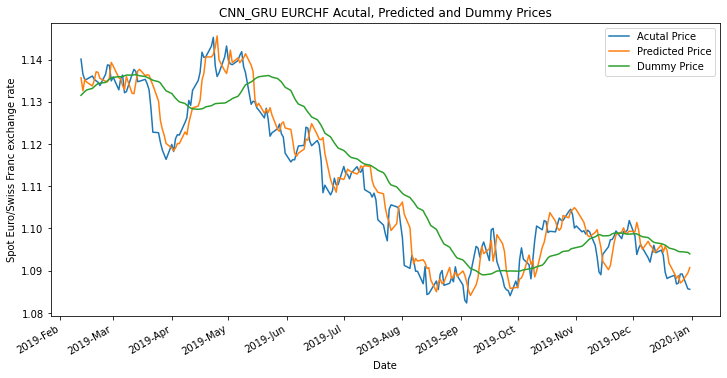

In [23]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

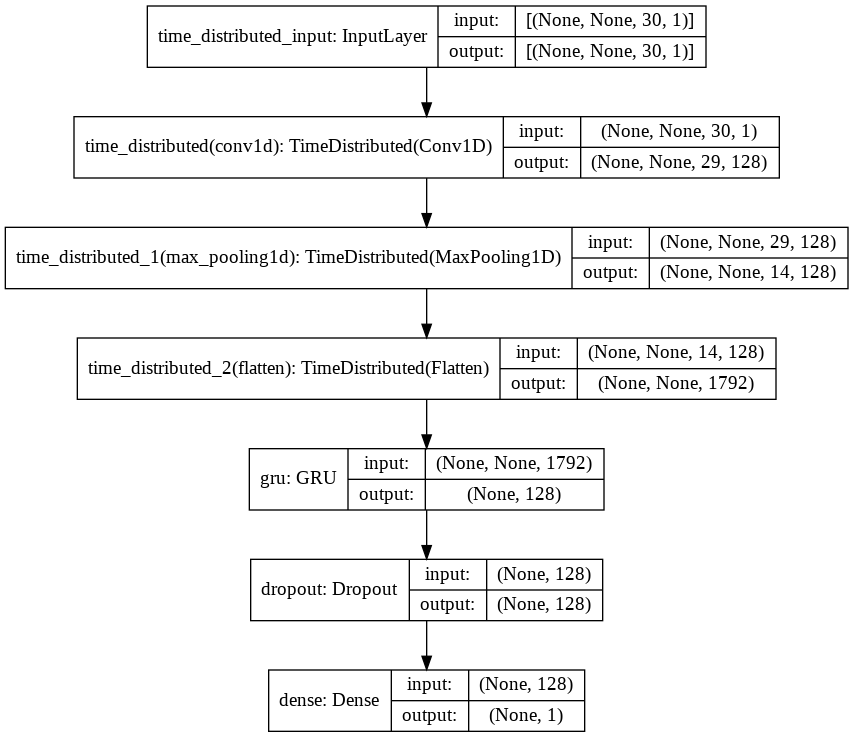

In [24]:
plot_model(model, show_shapes=True, expand_nested=True)

In [25]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.004396933255059318
RMSE:  0.06630937531796931
MAE:  0.05234688887854319
Dummy MSE:  0.01696823190684472
Dummy RMSE:  0.13026216606077423
Dummy MAE:  0.10864031818078547


In [26]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_EURCHF/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_EURCHF/assets
